In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
import gym

In [2]:
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

transaction_cost = .001

In [73]:
daily_eth = pd.read_csv('../data/ETH-USD_hr_24.csv', sep=',')
#daily_eth["time"] = pd.to_datetime(daily_eth['time'], unit='s')

In [74]:
# assumption: make decision at open of trading period
# shift these cols
shift_header = ['low', 'high', 'open','close', 'volume']
for col in shift_header:
    new_header = f'last_{col}'
    daily_eth[new_header] = daily_eth[col].shift(1)

In [75]:
daily_eth = daily_eth.rename(columns={'open':'current_open', 'close':'target_close'})

In [76]:
# drop unnecessary col
drop_headers = ['low', 'high', 'volume']
daily_eth = daily_eth.drop(drop_headers, axis = 1)

In [77]:
# rearrange cols
daily_eth = daily_eth[['time', 'last_low', 'last_high', 'last_open','last_close','last_volume', 'current_open', 'target_close']]

In [78]:
def label_trade(diff):
    if(abs(diff) <= transaction_cost):
        return 0
    elif diff > transaction_cost:
        return 1
    else:
        return -1

In [79]:
daily_eth['target_return'] = (daily_eth['target_close'] - daily_eth['current_open']) / daily_eth['current_open']
daily_eth['target_trade'] = daily_eth['target_return'].apply(label_trade)


In [82]:
daily_eth['target_trade'].value_counts()

 1    389
-1    307
 0     16
Name: target_trade, dtype: int64

In [81]:
daily_eth.to_csv('labeled_daily_eth.csv', header=True, index=False, mode='w')

In [89]:
# drop first time period
daily_eth = daily_eth.dropna()

# assumptions:
# perfect close prediction
# end period in cash
# 0 cost to short sell
daily_eth['profit'] = daily_eth['target_return'] * daily_eth['target_trade'] * daily_eth['target_close'] * (1 - transaction_cost)
daily_eth['profit'].sum()

40357.03075570814

In [90]:
daily_eth['target_trade'].value_counts()

 1    389
-1    306
 0     16
Name: target_trade, dtype: int64

<AxesSubplot:>

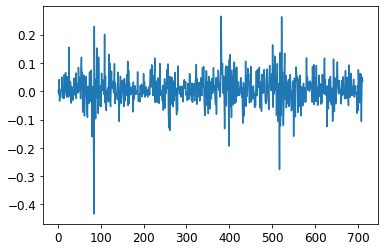

In [91]:
daily_eth['target_return'].plot()

In [17]:
slippage = (daily_eth['open'] - daily_eth['last_close']) / daily_eth['last_close']

In [ ]:
slippage.describe()

In [92]:
def partition(feature_matrix, target_vector, t):
    split = int(len(feature_matrix) * (1-t))

    X_train = feature_matrix[:split]
    X_test = feature_matrix[split:]

    y_train = target_vector[:split]
    y_test = target_vector[split:]

    return X_train, X_test, y_train, y_test

In [96]:
feature_matrix = daily_eth.drop(columns=['time', 'target_close', 'target_trade', 'target_return', 'profit'])

# target_close - regression
# target_trade - classification {-1 : sell, 0: cash, 1: buy}
target = daily_eth['target_trade']

In [109]:
# partition into 80% train, 20% test
X_train, X_test, y_train, y_test = partition(feature_matrix, target, 0.2)

array([[<AxesSubplot:title={'center':'last_low'}>,
        <AxesSubplot:title={'center':'last_high'}>],
       [<AxesSubplot:title={'center':'last_open'}>,
        <AxesSubplot:title={'center':'last_close'}>],
       [<AxesSubplot:title={'center':'last_volume'}>,
        <AxesSubplot:title={'center':'current_open'}>]], dtype=object)

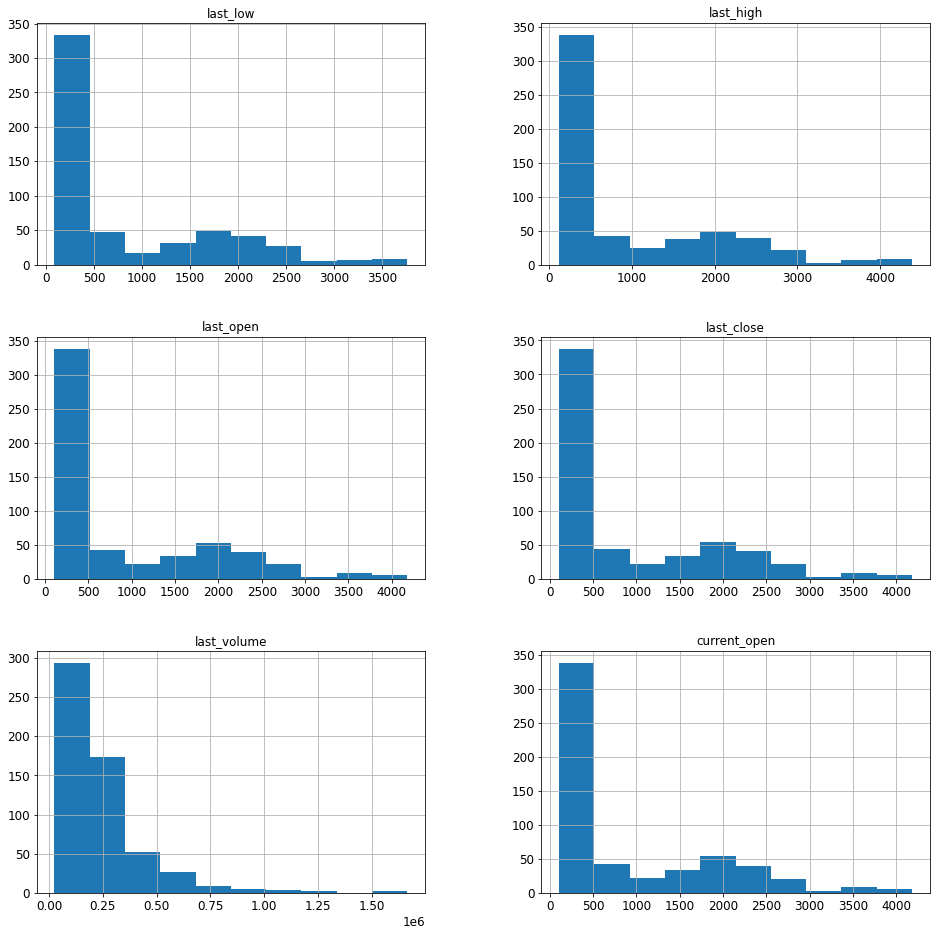

In [98]:
X_train.hist(figsize=(16, 16))

<AxesSubplot:>

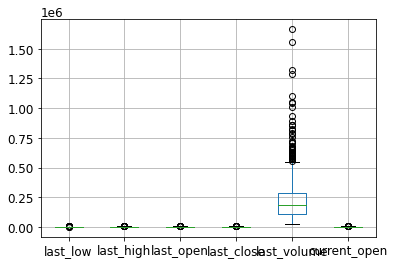

In [99]:
# very different range for each variable
X_train.boxplot()

In [102]:
X_train.describe().T.round(4)

,count,mean,std,min,25%,50%,75%,max
last_low,568.0,842.2307,874.2236,90.0000,217.2200,375.6850,1510.2225,3.760000e+03
last_high,568.0,928.8202,979.1147,118.8800,230.4975,399.1300,1699.4250,4.384430e+03
last_open,568.0,888.9329,932.2093,110.3000,224.3125,387.4450,1601.8825,4.179770e+03
last_close,568.0,892.4294,933.0923,110.3000,224.7100,387.7050,1617.8150,4.179760e+03
last_volume,568.0,240549.2279,205716.3921,25941.7402,111819.0715,180530.1032,287733.5827,1.664159e+06
current_open,568.0,892.4248,933.0867,110.3000,224.8275,387.6550,1617.9500,4.179770e+03


In [110]:
# differencing
X_train = X_train.pct_change()
X_train.dropna()

,last_low,last_high,last_open,last_close,last_volume,current_open
2,0.000239,-0.035717,-0.035443,0.001482,-0.527550,0.001404
3,0.007318,-0.006727,0.001404,-0.009971,-0.415453,-0.009349
4,0.002053,0.037135,-0.009349,0.041781,0.558876,0.041208
5,-0.005753,0.015163,0.041208,-0.034894,0.539273,-0.035121
6,0.002695,-0.042443,-0.035121,-0.000548,-0.438116,-0.000626
...,...,...,...,...,...,...
564,0.036618,0.066764,0.033145,0.043198,0.280327,0.043013
565,-0.013951,-0.027113,0.043013,-0.054155,0.235726,-0.054204
566,0.016213,0.010996,-0.054204,0.056659,0.061430,0.056823
567,0.045166,0.026038,0.056823,-0.002162,-0.036160,-0.001964


In [111]:
X_train.describe().T.round(4)

,count,mean,std,min,25%,50%,75%,max
last_low,567.0,0.0067,0.0571,-0.4408,-0.0155,0.0105,0.0302,0.3412
last_high,567.0,0.0061,0.0458,-0.2435,-0.0163,-0.0006,0.0277,0.2863
last_open,567.0,0.0067,0.0570,-0.4333,-0.0206,0.0048,0.0351,0.2646
last_close,567.0,0.0066,0.0571,-0.4332,-0.0206,0.0048,0.0350,0.2646
last_volume,567.0,0.1412,0.6702,-0.7847,-0.2733,-0.0159,0.4093,5.1526
current_open,567.0,0.0067,0.0571,-0.4333,-0.0206,0.0048,0.0351,0.2646


array([[<AxesSubplot:title={'center':'last_low'}>,
        <AxesSubplot:title={'center':'last_high'}>],
       [<AxesSubplot:title={'center':'last_open'}>,
        <AxesSubplot:title={'center':'last_close'}>],
       [<AxesSubplot:title={'center':'last_volume'}>,
        <AxesSubplot:title={'center':'current_open'}>]], dtype=object)

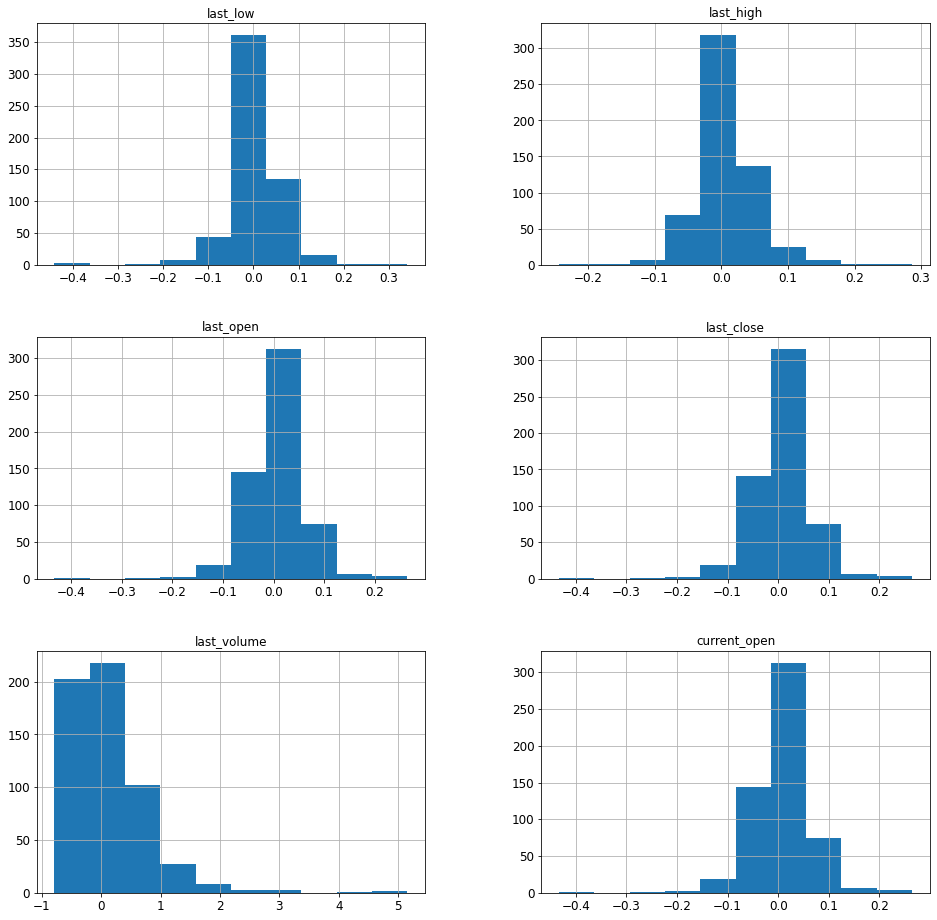

In [112]:
X_train.hist(figsize=(16, 16))

<AxesSubplot:>

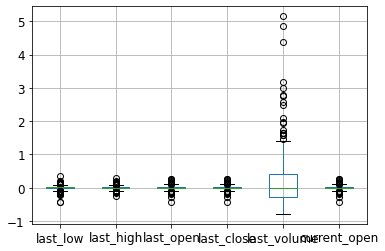

In [113]:
X_train.boxplot()

LTSM Autoencoder as feature detector
n Inputs must = n of Outputs
3 months - 90 days
input layer = 90 x 5 (low, high, open, close, vol)
hidden 1 = 32?
hidden 2 = 32?
output layer = 90 x 5

Building a recurrent autoencoder is straightforward: the encoder
is typically a sequence-to-vector RNN which compresses the input
sequence down to a single vector. The decoder is a vector-to-sequence RNN
that does the reverse:

In [88]:
n_features = 5 # (low, high, open, close, vol)
window_length = 90

# sequence-to-vector RNN
recurrent_encoder = keras.models.Sequential([
keras.layers.LSTM(100, return_sequences=True, input_shape=[None, n_features]),
keras.layers.LSTM(30)
])

# vector-to-sequence RNN
recurrent_decoder = keras.models.Sequential([
keras.layers.RepeatVector(n_features, input_shape=[30]),
keras.layers.LSTM(100, return_sequences=True),
keras.layers.TimeDistributed(keras.layers.Dense(n_features, activation="tanh"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

recurrent_ae.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 30)                58120     
                                                                 
 sequential_14 (Sequential)  (None, 5, 5)              52905     
                                                                 
Total params: 111,025
Trainable params: 111,025
Non-trainable params: 0
_________________________________________________________________


In [89]:
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=['accuracy'])

In [92]:
# need to reshape X_train to 3D [batch size, time steps, n_features]
X_train.shape

(568, 5)

In [90]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10


ValueError: in user code:

    File "/home/wsl/neural_network/neural_network/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/wsl/neural_network/neural_network/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/wsl/neural_network/neural_network/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/wsl/neural_network/neural_network/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/home/wsl/neural_network/neural_network/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/wsl/neural_network/neural_network/lib/python3.8/site-packages/keras/engine/input_spec.py", line 213, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_13" (type Sequential).
    
    Input 0 of layer "lstm_16" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 5)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 5), dtype=float32)
      • training=True
      • mask=None
